# Milestone 2

Nama : Muhamad Natual Hisak

Batch : FTDS-016-RMT

Dataset : Cheetah vs Hyena Dataset<br> (https://www.kaggle.com/datasets/singhdatascientist/for-image-classification-of-cheetah-vs-hyena)

Objective : Image Classification antara Cheetah atau Hyena

# 2. Import Library

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import cv2
import joblib
import os
import glob
from tensorflow import keras
import tensorflow as tf

from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Conv2D, MaxPooling2D,Dense,Dropout,Flatten
from sklearn.metrics import classification_report, confusion_matrix 

import warnings
warnings.filterwarnings('ignore')

# 3. Data Loading

Definisikan path yang berisi dataset gambar ke dalam variabel

In [3]:
main_path = r'C:\Users\Omen\Desktop\Hacktiv8\P2\Milestone 2'

definisikan path data train, val, dan inference ke dalam variabel

In [4]:
train_dir = os.path.join(main_path, 'train')
val_dir = os.path.join(main_path, 'validation')
inf_dir = os.path.join(main_path, 'inference')

Lihat jumlah data untuk train, val, dan inf cheetah dan hyena

In [5]:
num_cheetah_train = len(os.listdir(os.path.join(train_dir, 'cheetah')))
num_hyena_train = len(os.listdir(os.path.join(train_dir, 'hyena')))
num_cheetah_val = len(os.listdir(os.path.join(val_dir, 'cheetah')))
num_hyena_val = len(os.listdir(os.path.join(val_dir, 'hyena')))
num_cheetah_inf = len(os.listdir(os.path.join(inf_dir, 'cheetah')))
num_hyena_inf = len(os.listdir(os.path.join(inf_dir, 'hyena')))
print(f'jumlah cheetah train = {num_cheetah_train}')
print(f'jumlah hyena train = {num_hyena_train}')
print(f'jumlah cheetah val = {num_cheetah_val}')
print(f'jumlah hyena val = {num_hyena_val}')
print(f'jumlah cheetah inf = {num_cheetah_inf}')
print(f'jumlah hyena inf = {num_hyena_inf}')

jumlah cheetah train = 890
jumlah hyena train = 890
jumlah cheetah val = 100
jumlah hyena val = 100
jumlah cheetah inf = 10
jumlah hyena inf = 10


Select semua gambar di tiap directory

In [6]:
train_cheetah = glob.glob(train_dir+"\cheetah\*.jpg")
train_hyena = glob.glob(train_dir+"\hyena\*.jpg")

val_cheetah = glob.glob(val_dir+"\cheetah\*.jpg")
val_hyena = glob.glob(val_dir+"\hyena\*.jpg")

inf_cheetah = glob.glob(inf_dir+"\cheetah\*.jpg")
inf_hyena = glob.glob(inf_dir+"\hyena\*.jpg")

# 4. EDA

Jadikan data tiap gambar dan labelnya menjadi dataframe

In [7]:
def create_dataframe(list_of_images) :
    data = []
    for image in list_of_images :
        data.append((image, image.split('\\')[-2]))
    return pd.DataFrame(data,columns=['images','label'])

train_df = create_dataframe(train_cheetah + train_hyena)
train_df = train_df.sample(frac=1,random_state=1).reset_index(drop=True)

val_df = create_dataframe(val_cheetah + val_hyena)
val_df = val_df.sample(frac=1,random_state=1).reset_index(drop=True)

inf_df = create_dataframe(inf_cheetah + inf_hyena)
inf_df = inf_df.sample(frac=1,random_state=1).reset_index(drop=True)

In [8]:
inf_df.head()

,images,label
0,C:\Users\Omen\Desktop\Hacktiv8\P2\Milestone 2\...,cheetah
1,C:\Users\Omen\Desktop\Hacktiv8\P2\Milestone 2\...,hyena
2,C:\Users\Omen\Desktop\Hacktiv8\P2\Milestone 2\...,cheetah
3,C:\Users\Omen\Desktop\Hacktiv8\P2\Milestone 2\...,hyena
4,C:\Users\Omen\Desktop\Hacktiv8\P2\Milestone 2\...,cheetah


Ambil sampel tiap class

In [20]:
cheetah_samples = (train_df[train_df['label'] =='cheetah']['images'].iloc[:5]).tolist()
hyena_samples = (train_df[train_df['label'] =='hyena']['images'].iloc[:5]).tolist()

Visualisasikan sampel diatas

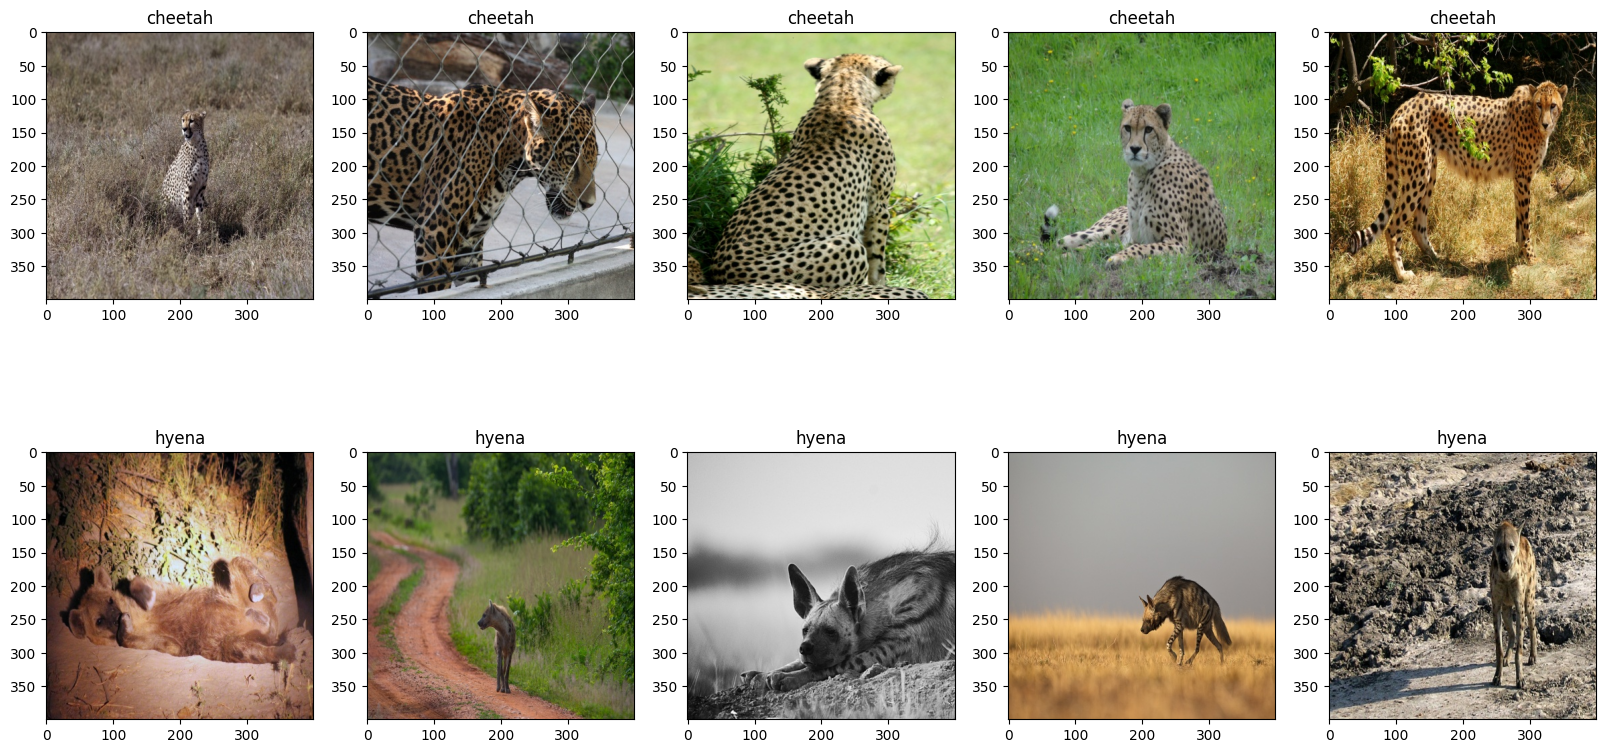

In [21]:
def visualize_samples(samples) :
    fig, ax = plt.subplots(nrows = 2, ncols = 5, figsize = (20,10))
    for i, sample in enumerate(samples) :
        img = cv2.imread(sample)
        ax[i//5, i%5].set_title(sample.split('\\')[-2])
        ax[i//5, i%5].imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
    plt.show()

visualize_samples(cheetah_samples + hyena_samples)

# 5. Data Preprocessing

Lakukan Augmentasi Data

rescale image dengan membagi dengan 255 agar rentang value ternormalisasi antara angka 0 dan 1.

angka 255 didapat dari dimensi warna RGB yang memiliki data 8 bit tiap warna (range tiap warna 0 sampai 255 atau ada 256 kemungkinan).

In [22]:
train_datagen = ImageDataGenerator(
    rescale = 1./255, #normalize pixel
)

val_datagen = ImageDataGenerator(rescale = 1./255)

In [23]:
ds_train = train_datagen.flow_from_dataframe(
    dataframe = train_df,
    x_col = 'images',
    y_col = 'label',
    class_mode = 'binary',
    target_size=(200, 200),
    batch_size = 32,
    shuffle = True,
    seed = 1
)

ds_val = val_datagen.flow_from_dataframe(
    dataframe = val_df,
    x_col = 'images',
    y_col = 'label',
    class_mode = 'binary',
    target_size=(200, 200),
    batch_size = 32,
    shuffle = False,
    seed = 1
)

Found 1780 validated image filenames belonging to 2 classes.
Found 200 validated image filenames belonging to 2 classes.


In [24]:
ds_train.class_indices

{'cheetah': 0, 'hyena': 1}

# 6. Modeling

Definisikan model dengan Sequential API

In [25]:
inputs= [200,200,3]

#arsitektur model sequential
model_seq= Sequential()

#Layer Conv 1
model_seq.add(Conv2D(filters=16, kernel_size=3, activation='relu',
                       input_shape=inputs))
model_seq.add(MaxPooling2D(pool_size= 2, strides=2))

#Layer Conv 2
model_seq.add(Conv2D(filters=32, kernel_size=3, activation='relu',
                       ))
model_seq.add(MaxPooling2D(pool_size= 2, strides=2))

#Layer Conv 3
model_seq.add(Conv2D(filters=64, kernel_size=3, activation='relu'))
model_seq.add(MaxPooling2D(pool_size= 2, strides=2))

model_seq.add(Flatten())
model_seq.add(Dense(units=128, activation='relu'))
model_seq.add(Dense(units=1,activation='sigmoid'))
model_seq.compile(optimizer='Adam', loss='binary_crossentropy', metrics= ['accuracy'])

Model ini menggunakan 3 layer convolution. Pada layer ke 3, ada 2 hidden layers dengan jumlah neuron 128 dan 1. Digunakan activation function relu dan optimizer Adam. Metric yang dilihat adalah accuracy

In [26]:
model_seq.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 198, 198, 16)      448       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 99, 99, 16)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 97, 97, 32)        4640      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 48, 48, 32)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 46, 46, 64)        18496     
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 23, 23, 64)       0

ada 4.357.409 parameter yang bisa di train

lihat skema model 

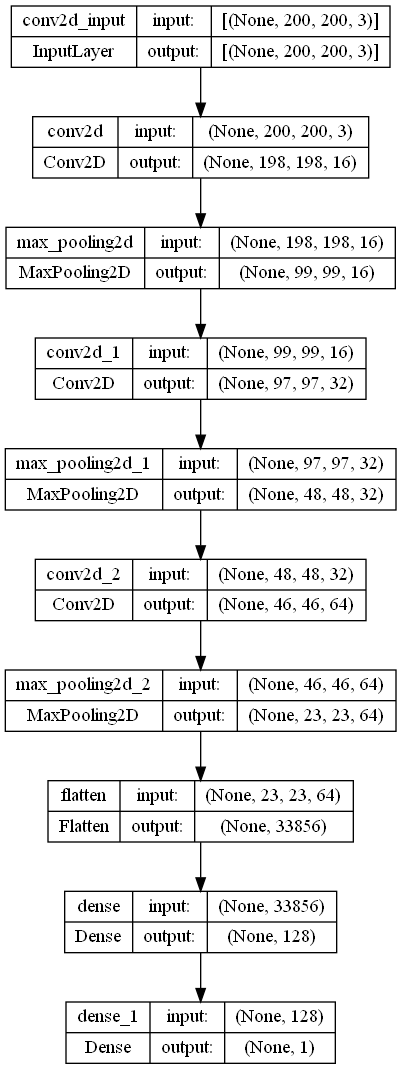

In [27]:
tf.keras.utils.plot_model(model_seq, show_shapes=True)

lakukan fit dengan 50 epoch 

In [28]:
history= model_seq.fit(ds_train, batch_size= 32, 
                           epochs= 50, validation_data= ds_val
                           )

Epoch 1/50
56/56 [==============================] - 23s 397ms/step - loss: 0.6436 - accuracy: 0.6393 - val_loss: 0.4142 - val_accuracy: 0.8000
Epoch 2/50
56/56 [==============================] - 22s 384ms/step - loss: 0.3970 - accuracy: 0.8185 - val_loss: 0.3173 - val_accuracy: 0.8650
Epoch 3/50
56/56 [==============================] - 22s 384ms/step - loss: 0.2743 - accuracy: 0.8792 - val_loss: 0.2457 - val_accuracy: 0.9000
Epoch 4/50
56/56 [==============================] - 22s 383ms/step - loss: 0.2248 - accuracy: 0.9112 - val_loss: 0.4839 - val_accuracy: 0.8450
Epoch 5/50
56/56 [==============================] - 21s 379ms/step - loss: 0.1492 - accuracy: 0.9438 - val_loss: 0.3076 - val_accuracy: 0.8850
Epoch 6/50
56/56 [==============================] - 21s 380ms/step - loss: 0.0908 - accuracy: 0.9657 - val_loss: 0.4276 - val_accuracy: 0.8750
Epoch 7/50
56/56 [==============================] - 21s 380ms/step - loss: 0.0451 - accuracy: 0.9837 - val_loss: 0.4209 - val_accuracy: 0.8850

jadikan loss dan akurasi train dan val kedalam dataframe

In [29]:
# Create DataFrame

history_seq_df = pd.DataFrame(history.history)
history_seq_df

,loss,accuracy,val_loss,val_accuracy
0,0.643613,0.639326,0.414243,0.800
1,0.397047,0.818539,0.317292,0.865
2,0.274294,0.879214,0.245682,0.900
3,0.224751,0.911236,0.483903,0.845
4,0.149242,0.943820,0.307563,0.885
5,0.090812,0.965730,0.427596,0.875
6,0.045078,0.983708,0.420912,0.885
7,0.044856,0.984831,0.373664,0.885
8,0.044778,0.983146,0.557667,0.860
9,0.025855,0.991573,0.454887,0.880


Lihat grafiknya

<AxesSubplot:>

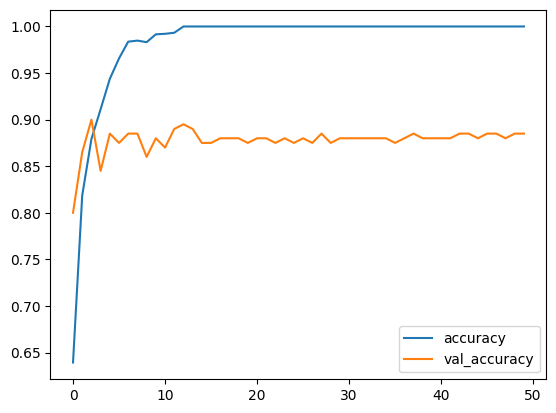

In [30]:
history_seq_df[['accuracy', 'val_accuracy']].plot()

<AxesSubplot:>

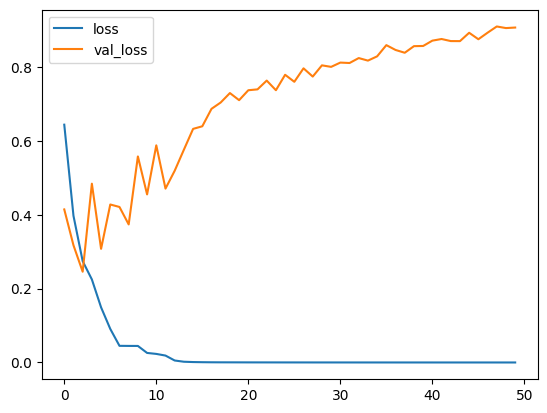

In [31]:
# Plot between loss and val_loss

history_seq_df[['loss', 'val_loss']].plot()

In [32]:
# Model Evaluation

test_results = model_seq.evaluate(ds_val, verbose=0)
print(f'Test Loss     : {test_results[0]:.4f}')
print(f'Test Accuracy : {test_results[1]:.4f}')

Test Loss     : 0.9065
Test Accuracy : 0.8850


Bisa dilihat model memiliki test accuracy yang sangat tinggi yaitu 88% dan loss 0.90. Model ini bisa dibilang overfit karena pada data train, akurasi yang didapat 100%.

# 7. Model Improvement

Lakukan Reduksi pada ukuran gambar dari 200x200 menjadi 64x64

In [33]:
ds_train_imp = train_datagen.flow_from_dataframe(
    dataframe = train_df,
    x_col = 'images',
    y_col = 'label',
    class_mode = 'binary',
    target_size=(64, 64),
    batch_size = 32,
    shuffle = True,
    seed = 1
)

ds_val_imp = val_datagen.flow_from_dataframe(
    dataframe = val_df,
    x_col = 'images',
    y_col = 'label',
    class_mode = 'binary',
    target_size=(64, 64),
    batch_size = 32,
    shuffle = False,
    seed = 1
)

Found 1780 validated image filenames belonging to 2 classes.
Found 200 validated image filenames belonging to 2 classes.


Train lagi dengan struktur model yang sama

In [34]:
inputs= [64,64,3]

#arsitektur model sequential
model_seq_imp= Sequential()

#Layer Conv 1, bisa coba atur kernel_initializer dan activation
model_seq_imp.add(Conv2D(filters=16, kernel_size=3, activation='relu',
                       input_shape=inputs))
model_seq_imp.add(MaxPooling2D(pool_size= 2, strides=2))

#Layer Conv 2
model_seq_imp.add(Conv2D(filters=32, kernel_size=3, activation='relu',
                      #  padding='same'
                       ))
model_seq_imp.add(MaxPooling2D(pool_size= 2, strides=2))

#Layer Conv 3
model_seq_imp.add(Conv2D(filters=64, kernel_size=3, activation='relu'))
model_seq_imp.add(MaxPooling2D(pool_size= 2, strides=2))

model_seq_imp.add(Flatten())
model_seq_imp.add(Dense(units=128, activation='relu'))
model_seq_imp.add(Dense(units=1,activation='sigmoid'))
model_seq_imp.compile(optimizer='Adam', loss='binary_crossentropy', metrics= ['accuracy'])

In [35]:
model_seq_imp.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_3 (Conv2D)           (None, 62, 62, 16)        448       
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 31, 31, 16)       0         
 2D)                                                             
                                                                 
 conv2d_4 (Conv2D)           (None, 29, 29, 32)        4640      
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 14, 14, 32)       0         
 2D)                                                             
                                                                 
 conv2d_5 (Conv2D)           (None, 12, 12, 64)        18496     
                                                                 
 max_pooling2d_5 (MaxPooling  (None, 6, 6, 64)        

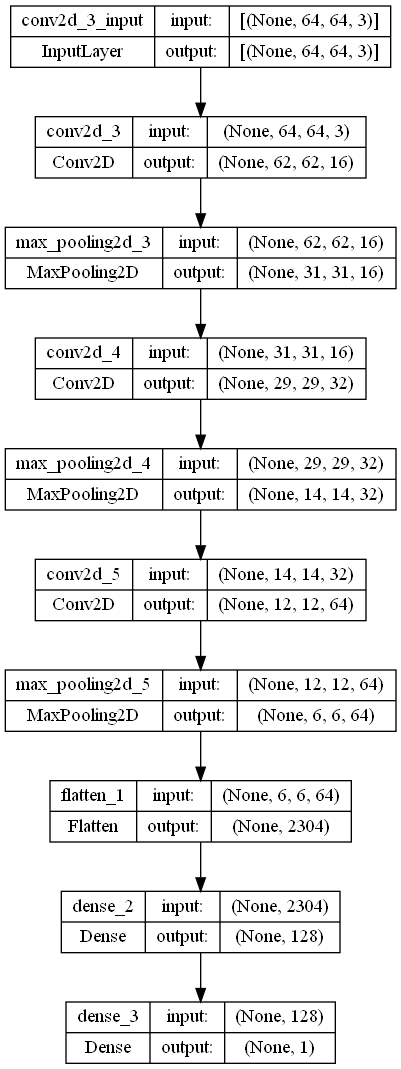

In [36]:
tf.keras.utils.plot_model(model_seq_imp, show_shapes=True)

In [37]:
history_imp= model_seq_imp.fit(ds_train_imp, batch_size= 32, 
                           epochs= 50, validation_data= ds_val_imp
                           )

Epoch 1/50
56/56 [==============================] - 4s 69ms/step - loss: 0.6098 - accuracy: 0.6629 - val_loss: 0.4249 - val_accuracy: 0.7850
Epoch 2/50
56/56 [==============================] - 3s 62ms/step - loss: 0.4539 - accuracy: 0.7854 - val_loss: 0.3386 - val_accuracy: 0.8500
Epoch 3/50
56/56 [==============================] - 4s 65ms/step - loss: 0.3954 - accuracy: 0.8230 - val_loss: 0.3141 - val_accuracy: 0.8800
Epoch 4/50
56/56 [==============================] - 3s 62ms/step - loss: 0.3316 - accuracy: 0.8489 - val_loss: 0.2828 - val_accuracy: 0.8850
Epoch 5/50
56/56 [==============================] - 3s 62ms/step - loss: 0.2783 - accuracy: 0.8837 - val_loss: 0.2089 - val_accuracy: 0.9150
Epoch 6/50
56/56 [==============================] - 4s 63ms/step - loss: 0.2294 - accuracy: 0.9084 - val_loss: 0.2112 - val_accuracy: 0.9350
Epoch 7/50
56/56 [==============================] - 3s 62ms/step - loss: 0.2047 - accuracy: 0.9213 - val_loss: 0.1814 - val_accuracy: 0.9250
Epoch 8/50
56

Jadikan hasil yang didapat ke dalam dataframe

In [38]:
# Create DataFrame

history_imp_df = pd.DataFrame(history_imp.history)
history_imp_df

,loss,accuracy,val_loss,val_accuracy
0,0.609830,0.662921,0.424911,0.785
1,0.453859,0.785393,0.338582,0.850
2,0.395405,0.823034,0.314096,0.880
3,0.331649,0.848876,0.282807,0.885
4,0.278321,0.883708,0.208868,0.915
5,0.229443,0.908427,0.211214,0.935
6,0.204696,0.921348,0.181361,0.925
7,0.176809,0.931461,0.177524,0.935
8,0.163699,0.939888,0.185702,0.935
9,0.150024,0.941011,0.151894,0.925


Lihat grafiknya

<AxesSubplot:>

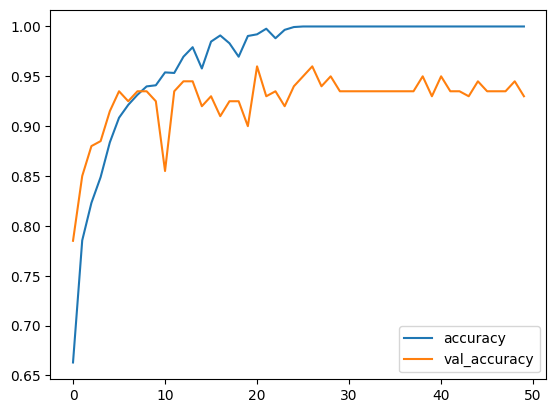

In [39]:
history_imp_df[['accuracy', 'val_accuracy']].plot()

<AxesSubplot:>

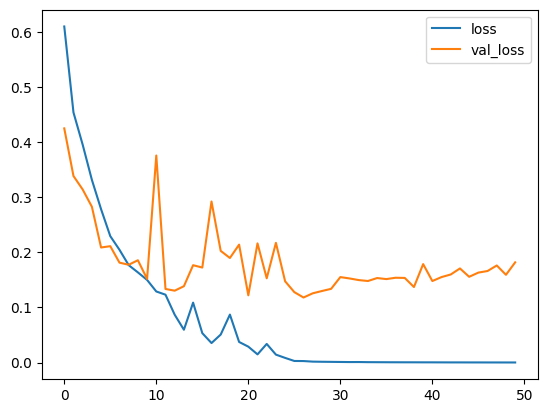

In [40]:
# Plot between loss and val_loss

history_imp_df[['loss', 'val_loss']].plot()

In [41]:
# Model Evaluation

test_results1 = model_seq_imp.evaluate(ds_val_imp, verbose=0)
print(f'Test Loss     : {test_results1[0]:.4f}')
print(f'Test Accuracy : {test_results1[1]:.4f}')

Test Loss     : 0.1819
Test Accuracy : 0.9300


Bisa dilihat akurasi test bertambah dari 88% ke 93%. Loss juga berkurang dari 0.90 menjadi 0.1. Waktu yang dibutuhkan untuk training juga jauh lebih cepat dari base model yaitu 17.5 menit menjadi hanya kurang dari 3 menit

# 8. Model Saving

In [42]:
# Summary of Model Sequential Improved

model_seq_imp.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_3 (Conv2D)           (None, 62, 62, 16)        448       
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 31, 31, 16)       0         
 2D)                                                             
                                                                 
 conv2d_4 (Conv2D)           (None, 29, 29, 32)        4640      
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 14, 14, 32)       0         
 2D)                                                             
                                                                 
 conv2d_5 (Conv2D)           (None, 12, 12, 64)        18496     
                                                                 
 max_pooling2d_5 (MaxPooling  (None, 6, 6, 64)        

Freeze model

In [43]:

model_seq_imp.trainable = False
model_seq_imp.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_3 (Conv2D)           (None, 62, 62, 16)        448       
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 31, 31, 16)       0         
 2D)                                                             
                                                                 
 conv2d_4 (Conv2D)           (None, 29, 29, 32)        4640      
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 14, 14, 32)       0         
 2D)                                                             
                                                                 
 conv2d_5 (Conv2D)           (None, 12, 12, 64)        18496     
                                                                 
 max_pooling2d_5 (MaxPooling  (None, 6, 6, 64)        

Simpan model dengan nama model.h5

In [44]:
# Save CNN Model

model_seq_imp.save('model.h5')

# 9. Model Inference

load model

In [20]:
model_cnn = load_model('model.h5')

Buat fungsi untuk predict

In [22]:
def predict(filename):
    img1 = image.load_img(filename, target_size=(64, 64))
    
    plt.imshow(img1)
    Y = image.img_to_array(img1)
    X = np.expand_dims(Y, axis=0)
    val = model_cnn.predict(X)
    if val == 1:
        plt.xlabel("A Hyena")
        print("A Hyena")
    elif val == 0:
        plt.xlabel("A Cheetah")
        print("A Cheetah")

Lakukan predict ke data inference

1/1 [==============================] - 0s 24ms/step
A Hyena
1/1 [==============================] - 0s 32ms/step
A Hyena
1/1 [==============================] - 0s 32ms/step
A Cheetah
1/1 [==============================] - 0s 24ms/step
A Hyena
1/1 [==============================] - 0s 25ms/step
A Cheetah
1/1 [==============================] - 0s 32ms/step
A Hyena
1/1 [==============================] - 0s 32ms/step
A Cheetah
1/1 [==============================] - 0s 32ms/step
A Hyena
1/1 [==============================] - 0s 24ms/step
A Hyena
1/1 [==============================] - 0s 24ms/step
A Cheetah
1/1 [==============================] - 0s 32ms/step
A Cheetah
1/1 [==============================] - 0s 32ms/step
A Cheetah
1/1 [==============================] - 0s 32ms/step
A Hyena
1/1 [==============================] - 0s 32ms/step
A Hyena
1/1 [==============================] - 0s 24ms/step
A Cheetah
1/1 [==============================] - 0s 24ms/step
A Hyena
1/1 [=====================

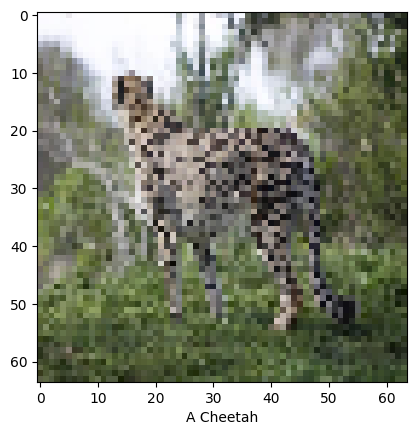

In [23]:
for i in inf_df['images'] :
    prediction = []
    predict(i)

In [10]:
pd.options.display.max_colwidth = 1000

In [17]:
inf_df

,images,label
0,C:\Users\Omen\Desktop\Hacktiv8\P2\Milestone 2\inference\cheetah\cheetah_893_resized.jpg,cheetah
1,C:\Users\Omen\Desktop\Hacktiv8\P2\Milestone 2\inference\hyena\hyena_896_resized.jpg,hyena
2,C:\Users\Omen\Desktop\Hacktiv8\P2\Milestone 2\inference\cheetah\cheetah_896_resized.jpg,cheetah
3,C:\Users\Omen\Desktop\Hacktiv8\P2\Milestone 2\inference\hyena\hyena_890_resized.jpg,hyena
4,C:\Users\Omen\Desktop\Hacktiv8\P2\Milestone 2\inference\cheetah\cheetah_892_resized.jpg,cheetah
5,C:\Users\Omen\Desktop\Hacktiv8\P2\Milestone 2\inference\hyena\hyena_894_resized.jpg,hyena
6,C:\Users\Omen\Desktop\Hacktiv8\P2\Milestone 2\inference\cheetah\cheetah_894_resized.jpg,cheetah
7,C:\Users\Omen\Desktop\Hacktiv8\P2\Milestone 2\inference\hyena\hyena_897_resized.jpg,hyena
8,C:\Users\Omen\Desktop\Hacktiv8\P2\Milestone 2\inference\cheetah\cheetah_897_resized.jpg,cheetah
9,C:\Users\Omen\Desktop\Hacktiv8\P2\Milestone 2\inference\cheetah\cheetah_891_resized.jpg,cheetah


Telaah data yang salah di prediksi 

1/1 [==============================] - 0s 267ms/step
[[1.]]


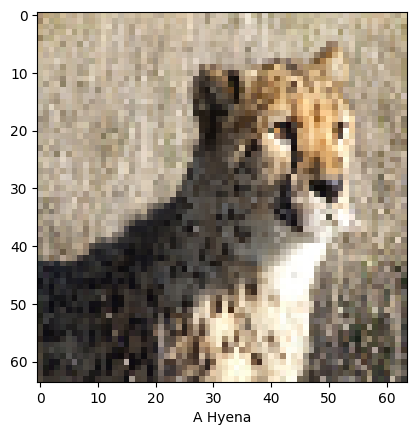

In [21]:
predict(r'C:\Users\Omen\Desktop\Hacktiv8\P2\Milestone 2\inference\cheetah\cheetah_893_resized.jpg')

1/1 [==============================] - 0s 24ms/step
A Hyena


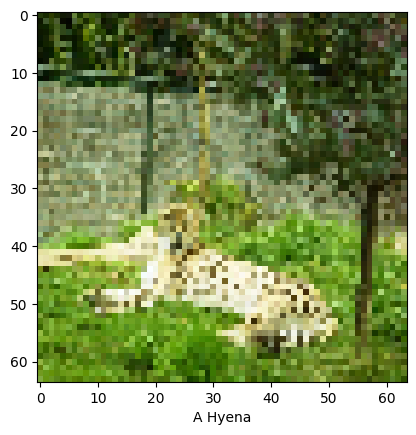

In [24]:
predict(r'C:\Users\Omen\Desktop\Hacktiv8\P2\Milestone 2\inference\cheetah\cheetah_897_resized.jpg')

1/1 [==============================] - 0s 24ms/step
A Cheetah


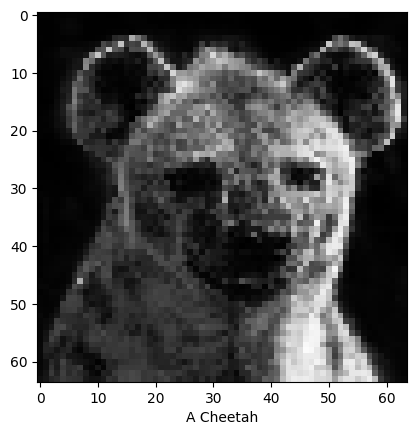

In [26]:
predict(r'C:\Users\Omen\Desktop\Hacktiv8\P2\Milestone 2\inference\hyena\hyena_893_resized.jpg')

1/1 [==============================] - 0s 19ms/step
A Cheetah


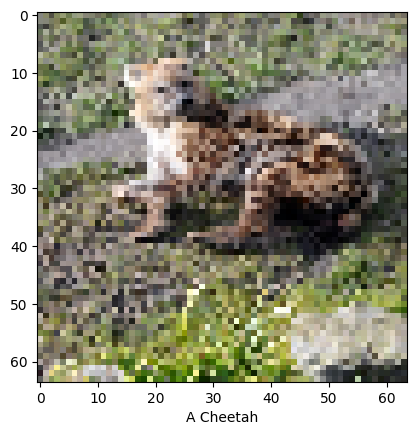

In [27]:
predict(r'C:\Users\Omen\Desktop\Hacktiv8\P2\Milestone 2\inference\hyena\hyena_892_resized.jpg')

# 10. Kesimpulan

1. Pada EDA, bisa dilihat dari sampel bahwa data semua memiliki ukuran yang sama yaitu 400x400

2. Data perfectly balanced karena jumlah data masing-masing class sama

3. Pada base model, dilakukan training dengan ukuran gambar 200x200 dan dengan model yang sudah didefinisikan diatas. Hasil yang didapat adalah akurasi test 88% dan loss 0.90. Model overfit karena akurasi test mencapai 100%. Waktu training 17.5 menit untuk 50 epochs

4. Model improvement yang dilakukan adalah mengubah ukuran gambar menjadi 64x64, lalu di train dengan skema model yang sama seperti base model. 

5. Hasil model yang sudah di improve adalah akurasi test naik menjadi 93% dan loss turun drastis hingga 0.1. Waktu training juga jauh lebih cepat yaitu 2 menit 57 detik.

6. Dari data inference, ada 4 kesalahan klasifikasi dari total 20 data yang berarti ada 5% kesalahan dari total data inference.

7. Jika dilihat dari hasil prediksi data inference, data yang salah di prediksi adalah data gambar yang close up ke wajah hewan yang bersangkutan atau data gambar yang hewan nya terlihat jauh pada gambar. Bisa juga disebabkan oleh tingkat kecerahan warna gambar sehingga mempengaruhi warna rambut dari hewan yang bersangkutan.